In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # Changed to MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
# Load dataset
file_path = "r_updated_all_highrisk.xlsx"  # Hubi in file extension-ku yahay .xlsx
df = pd.read_excel(file_path)
df

,Gender,Age,Diagnosis,Days in Hospital,Number of Procedures,Readmitted
0,M,32,Abdominal Injury,9,7,1
1,M,15,Depressed Skull Fracture,3,8,1
2,M,26,Diabetic Foot Gangrene,10,1,1
3,M,33,Multiple Injury,2,2,0
4,F,30,Multiple Injury,3,4,1
...,...,...,...,...,...,...
995,M,22,Right Wrist Injury,9,9,1
996,F,23,Left Hand Fingers Injury,5,9,0
997,M,20,Soft Tissue Injury Right Ankle Fracture,2,3,0
998,M,39,Diabetic Foot Gangrene,4,5,0


In [5]:

# Show basic info
print("🔍 Dataset Overview:")
print(df.info())  # Dataset structure


🔍 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Gender                1000 non-null   object
 1   Age                   1000 non-null   int64 
 2   Diagnosis             1000 non-null   object
 3   Days in Hospital      1000 non-null   int64 
 4   Number of Procedures  1000 non-null   int64 
 5   Readmitted            1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB
None


In [7]:
df.head()  # First 5 rows


,Gender,Age,Diagnosis,Days in Hospital,Number of Procedures,Readmitted
0,M,32,Abdominal Injury,9,7,1
1,M,15,Depressed Skull Fracture,3,8,1
2,M,26,Diabetic Foot Gangrene,10,1,1
3,M,33,Multiple Injury,2,2,0
4,F,30,Multiple Injury,3,4,1


In [9]:
print("\n📊 Summary statistics:")
print(df.describe())  # Summary statistics



📊 Summary statistics:
               Age  Days in Hospital  Number of Procedures   Readmitted
count  1000.000000       1000.000000           1000.000000  1000.000000
mean     29.388000          7.596000              4.917000     0.364000
std      16.635269          4.129144              2.548452     0.481389
min       5.000000          1.000000              1.000000     0.000000
25%      20.000000          4.000000              3.000000     0.000000
50%      26.000000          8.000000              5.000000     0.000000
75%      35.000000         11.000000              7.000000     1.000000
max      78.000000         14.000000              9.000000     1.000000


In [10]:

# Handle duplicates
print(f"\n❗ Duplicate Rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)  # Remove duplicates



❗ Duplicate Rows: 5


In [11]:

# Handle missing values
missing_values = df.isnull().sum()
print("\n🛑 Missing Values per Column:\n", missing_values[missing_values > 0])
df.dropna(subset=['Readmitted'], inplace=True)



🛑 Missing Values per Column:
 Series([], dtype: int64)


In [12]:

# Remove outliers using IQR method
numeric_columns = ['Age', 'Number of Procedures', 'Days in Hospital', ]
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]



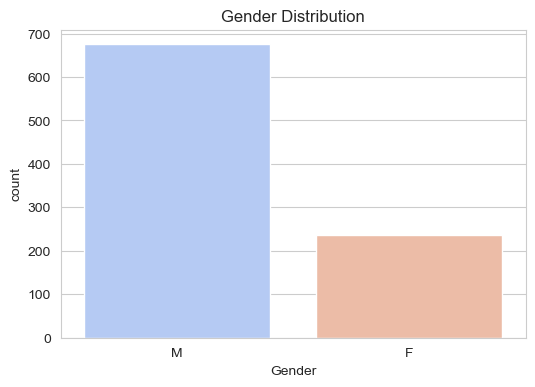

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', hue='Gender', palette='coolwarm', legend=False)
plt.title("Gender Distribution")
plt.show()


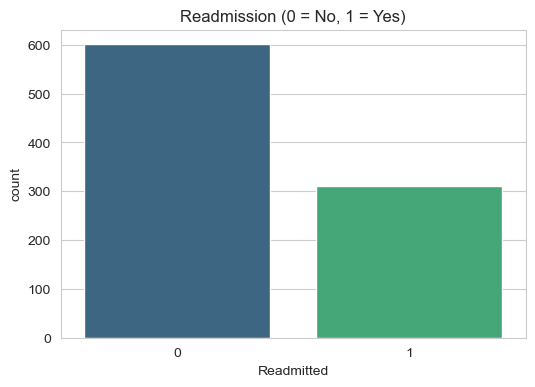

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Readmitted', hue='Readmitted', palette='viridis', legend=False)
plt.title("Readmission (0 = No, 1 = Yes)")
plt.show()


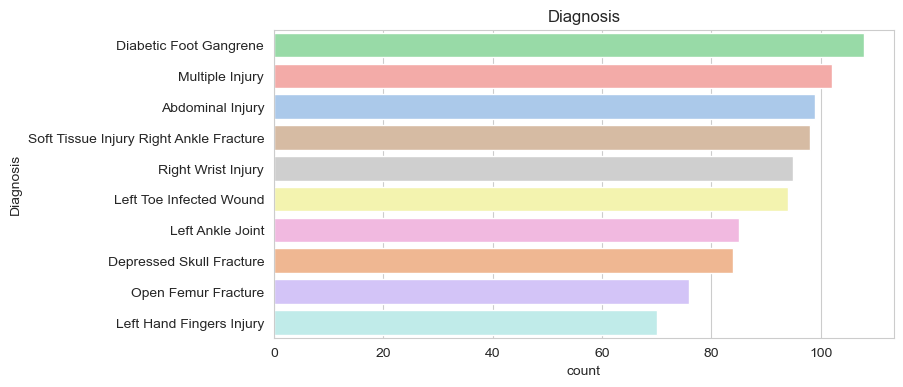

In [15]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, y='Diagnosis', hue='Diagnosis', order=df['Diagnosis'].value_counts().index, palette='pastel', legend=False)
plt.title("Diagnosis")
plt.show()


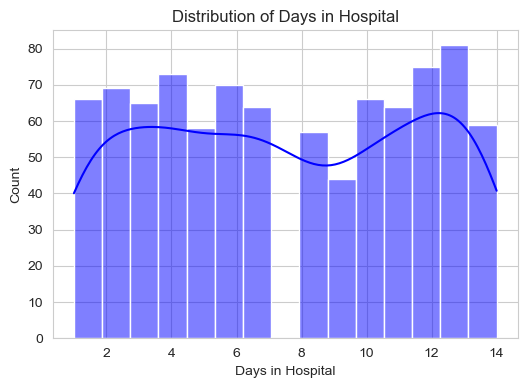

In [16]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Days in Hospital'], bins=15, kde=True, color='blue')
plt.title("Distribution of Days in Hospital")
plt.show()



In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
categorical_columns = ['Gender', 'Diagnosis', 'Readmitted']

for col in categorical_columns:
    df.loc[:, col] = encoder.fit_transform(df[col])  # Encoding categorical columns

# Show the encoded dataframe
print(df.head())


  Gender  Age Diagnosis  Days in Hospital  Number of Procedures  Readmitted
0      1   32         0                 9                     7           1
1      1   15         1                 3                     8           1
2      1   26         2                10                     1           1
3      1   33         6                 2                     2           0
4      0   30         6                 3                     4           1


In [19]:
# Scale numeric columns using MinMaxScaler
numeric_columns = ['Age', 'Number of Procedures', 'Days in Hospital']
scaler = MinMaxScaler()

# Fit and transform the data, then update the DataFrame
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Show updated dataset
df.head(10)

C:\Users\maxam\AppData\Local\Temp\ipykernel_9516\42380393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = scaler.fit_transform(df[numeric_columns])


,Gender,Age,Diagnosis,Days in Hospital,Number of Procedures,Readmitted
0,1,0.529412,0,0.615385,0.750,1
1,1,0.196078,1,0.153846,0.875,1
2,1,0.411765,2,0.692308,0.000,1
3,1,0.549020,6,0.076923,0.125,0
4,0,0.490196,6,0.153846,0.375,1
5,1,0.490196,7,0.769231,1.000,1
7,0,0.686275,9,0.076923,0.875,1
8,1,0.372549,0,0.153846,0.375,0
9,1,0.156863,3,0.461538,0.000,0
10,1,0.352941,8,0.000000,0.500,0


In [20]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Gender', 'Diagnosis',]
df_encoded = df.copy()

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le


In [21]:

# Define features and target variable
X = df_encoded.drop(columns=['Readmitted'])
y = df_encoded['Readmitted']

# Handle class imbalance using Oversampling
df_majority = df_encoded[df_encoded.Readmitted == 0]
df_minority = df_encoded[df_encoded.Readmitted == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [22]:
# Split data
X_balanced = df_balanced.drop(columns=['Readmitted'])
y_balanced = df_balanced['Readmitted']
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)



In [23]:
# Train Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_score_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f"\nLogistic Regression:\n", classification_report(y_test, y_pred_lr))
print(f"Logistic Regression -> Accuracy: {accuracy_lr:.4f}, AUC Score: {auc_score_lr:.4f}")




Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       118
           1       0.79      0.75      0.77       123

    accuracy                           0.77       241
   macro avg       0.77      0.77      0.77       241
weighted avg       0.77      0.77      0.77       241

Logistic Regression -> Accuracy: 0.7676, AUC Score: 0.8213


In [24]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_score_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print(f"\nXGBoost:\n", classification_report(y_test, y_pred_xgb))
print(f"XGBoost -> Accuracy: {accuracy_xgb:.4f}, AUC Score: {auc_score_xgb:.4f}")



C:\Users\maxam\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       118
           1       0.90      0.96      0.93       123

    accuracy                           0.93       241
   macro avg       0.93      0.92      0.93       241
weighted avg       0.93      0.93      0.93       241

XGBoost -> Accuracy: 0.9253, AUC Score: 0.9541


In [25]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
auc_score_lgb = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])
print(f"\nLightGBM:\n", classification_report(y_test, y_pred_lgb))
print(f"LightGBM -> Accuracy: {accuracy_lgb:.4f}, AUC Score: {auc_score_lgb:.4f}")



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 478, number of negative: 483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 961, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497399 -> initscore=-0.010406
[LightGBM] [Info] Start training from score -0.010406

LightGBM:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       118
           1       0.91      0.94      0.93       123

    accuracy                           0.93       241
   macro avg       0.93      0.92      0.93       241
weighted avg       0.93      0.93      0.93       241

LightGBM -> Accuracy: 0.9253, AU

In [26]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_score_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"\nRandom Forest:\n", classification_report(y_test, y_pred_rf))
print(f"Random Forest -> Accuracy: {accuracy_rf:.4f}, AUC Score: {auc_score_rf:.4f}")




Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       118
           1       0.95      0.96      0.96       123

    accuracy                           0.95       241
   macro avg       0.95      0.95      0.95       241
weighted avg       0.95      0.95      0.95       241

Random Forest -> Accuracy: 0.9544, AUC Score: 0.9631


In [27]:
# Train the final Random Forest model with the best hyperparameters
best_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

best_rf.fit(X_train, y_train)

# Evaluate on the test set
y_pred_final = best_rf.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Final Test AUC Score: {final_auc:.4f}")




Final Test Accuracy: 0.9544
Final Test AUC Score: 0.9615


In [28]:
# Save trained model
joblib.dump(best_rf, 'random_forest_model.pkl')

# Save feature scaler
joblib.dump(scaler, 'scaler.pkl')

# Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']